<a href="https://colab.research.google.com/github/JayNguyen-123/Hiring_Manager_AI/blob/main/Hiring_Manager_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### From traditional of Question and Answer task of LLM, today we will build sophiticated interview system to the AI..The AI will be the interviewer.
### Key Features
- Dynamic interview flow that adapts to candidate responses.
- Intelligent response evaluation on scale 1-10.
- Persistent state management to resume interupted interviews.
- Real-time progress tracking and response analysis.
- Smart follow-up questions based on missing information.

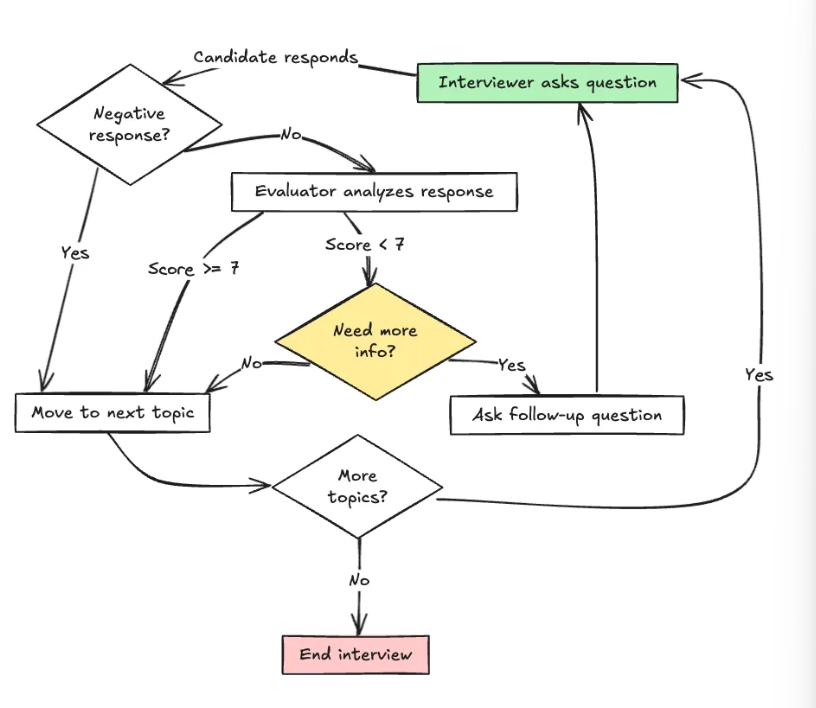



In [ ]:
!pip install langchain-community
langchain-openai
openai
streamlit
python-dotenv

In [ ]:
from typing import Dict
from collections import defaultdict
import json
import os


### The Memory System


In [ ]:
class InterviewMemory:
    def __init__(self):
        self.field_memory = defaultdict(list)
        self.current_responses = defaultdict(str)

    def add_response(self, field: str, response: str):
        """Add a new response to the field's history"""
        self.field_memory[field].append(response)
        self.current_responses[field] = " ".join(self.field_memory[field])

    def get_field_history(self, field: str) -> str:
        """Get the combined history of all responses for a field"""
        return self.current_responses[field]

    def get_latest_response(self, field: str) -> str:
        """Get only the most recent response"""
        return self.field_memory[field][-1] if self.field_memory[field] else ""

    def get_all_responses(self, field: str) -> list:
        """Get list of all responses for a field"""
        return self.field_memory[field]


### Interview Structure


In [ ]:
FIELD_REQUIREMENTS = {
    "name": {
        "description": "Full name of the candidate",
        "expected": "First and last name",
        "follow_up_questions": [
            "Could you spell your full name for me?",
            "Do you go by any other names professionally?"
        ]
    },
    "current_role": {
        "description": "Current job position and main responsibilities",
        "expected": "Job title, company, key responsibilities, team size, main achievements",
        "follow_up_questions": [
            "What are your main responsibilities in this role?",
            "How large is the team you work with?",
            "What have been your key achievements in this position?"
        ]
    },
    "years_of_experience": {
        "description": "Total relevant work experience",
        "expected": "Years of total experience, years in current field, career progression",
        "follow_up_questions": [
            "How long have you been working in this field specifically?",
            "Could you briefly outline your career progression?",
            "What different roles have you held during your career?"
        ]
    },
    "technical_skills": {
        "description": "Technical abilities and proficiency levels",
        "expected": "List of skills with proficiency levels (beginner/intermediate/expert), recent usage",
        "follow_up_questions": [
            "Could you rate your proficiency in each skill mentioned?",
            "How recently have you used these skills?",
            "What projects have you completed using these skills?"
        ]
    },
    "project_experience": {
        "description": "Significant projects and achievements",
        "expected": "Project descriptions, role, technologies used, outcomes, challenges overcome",
        "follow_up_questions": [
            "What was your specific role in these projects?",
            "What challenges did you face and how did you overcome them?",
            "What were the measurable outcomes of these projects?"
        ]
    },
    "motivation": {
        "description": "Career goals and motivation for the position",
        "expected": "Short-term and long-term goals, interest in the position, alignment with career path",
        "follow_up_questions": [
            "What interests you most about this position?",
            "Where do you see yourself in 5 years?",
            "How does this role align with your career goals?"
        ]
    },
    "preferred_work_environment": {
        "description": "Work style and preferred environment",
        "expected": "Preferred work style, team dynamics, company culture, work-life balance",
        "follow_up_questions": [
            "What type of company culture do you thrive in?",
            "How do you prefer to collaborate with team members?",
            "What management style works best for you?"
        ]
    }
}

interview_form = {
    "name": {"value": "", "satisfaction": 0},
    "current_role": {"value": "", "satisfaction": 0},
    "years_of_experience": {"value": "", "satisfaction": 0},
    "technical_skills": {"value": [], "satisfaction": 0},
    "project_experience": {"value": "", "satisfaction": 0},
    "motivation": {"value": "", "satisfaction": 0},
    "preferred_work_environment": {"value": "", "satisfaction": 0},
}

### Response Evaluation


In [ ]:
def evaluate_response(client, response: str, field: str, memory: InterviewMemory) -> Dict:
    try:
        # Get complete history for this field
        complete_response = memory.get_field_history(field)

        # Create the evaluation prompt
        evaluation_prompt = f"""
        You are evaluating a response for the field: {field}
        Expected information: {FIELD_REQUIREMENTS[field]['expected']}
        Complete response history: {complete_response}
        Latest response: {response}

        Please evaluate the complete response history and provide:
        1. A satisfaction score (1-10)
        2. A brief analysis
        3. Any missing information
        4. A follow-up question if needed

        Format your response as JSON:
        {{
            "satisfaction_score": <score>,
            "analysis": "<brief analysis>",
            "missing_info": "<list missing info or 'none'>",
            "follow_up_question": "<question to get missing info>"
        }}
        """

        # Get completion from OpenAI
        completion = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an expert interviewer evaluating responses."},
                {"role": "user", "content": evaluation_prompt}
            ],
            temperature=0.7
        )

        # Extract the response
        evaluation = json.loads(completion.choices[0].message.content)

        # Add default values if any key is missing
        evaluation.setdefault("satisfaction_score", 5)
        evaluation.setdefault("analysis", "Analysis not provided")
        evaluation.setdefault("missing_info", "None")
        evaluation.setdefault("follow_up_question", FIELD_REQUIREMENTS[field]['follow_up_questions'][0])

        return evaluation

    except Exception as e:
        print(f"Error in evaluation: {str(e)}")
        return {
            "satisfaction_score": 5,
            "analysis": "Error occurred during analysis",
            "missing_info": "Error in evaluation",
            "follow_up_question": FIELD_REQUIREMENTS[field]['follow_up_questions'][0] if field in FIELD_REQUIREMENTS else "Could you please provide more details?",
            "skip_topic": False
        }



### Negative Response Detection


In [ ]:
def is_negative_response(client, response: str) -> bool:
    """
    Use LLM to determine if the response is negative
    """
    try:
        prompt = f"""
        Analyze if this response indicates a clear negative
        Response: "{response}"

        Consider responses like:
        - "no"
        - "none"
        - "I don't have any experience"
        - "I haven't done that"
        - "nothing comes to mind"

        Return only "true" if it's clearly negative, or "false" otherwise.
        """

        completion = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are analyzing interview responses. Respond only with 'true' or 'false'."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1  # Low temperature for more consistent responses
        )

        result = completion.choices[0].message.content.strip().lower()
        return result == "true"

    except Exception as e:
        print(f"Error in negative response detection: {str(e)}")
        # Fall back to simple keyword matching if LLM fails
        negative_indicators = [
            "no", "none", "nothing", "don't have", "do not have",
            "nothing comes to mind", "haven't done any", "i don't",
            "no experience", "no projects"
        ]
        response_lower = response.lower().strip()
        return any(indicator in response_lower for indicator in negative_indicators)

In [ ]:
# Automatic state saving
def save_chat_history(messages: list, interview_form: dict, memory: InterviewMemory):
    """Save chat history and form data to a JSON file"""
    data = {
        "messages": messages,
        "interview_form": interview_form,
        "memory": {
            "field_memory": dict(memory.field_memory),
            "current_responses": dict(memory.current_responses)
        }
    }

    os.makedirs("chat_history", exist_ok=True)
    filename = "chat_history/interview.json"
    with open(filename, "w") as f:
        json.dump(data, f, indent=2)

def load_chat_history():
    """Load chat history and form data from JSON file"""
    filename = "chat_history/interview.json"
    try:
        with open(filename, "r") as f:
            data = json.load(f)

            # Create new memory instance and populate it
            memory = InterviewMemory()
            memory_data = data.get("memory", {})
            memory.field_memory = defaultdict(list, memory_data.get("field_memory", {}))
            memory.current_responses = defaultdict(str, memory_data.get("current_responses", {}))

            return data.get("messages", []), data.get("interview_form", {}), memory
    except FileNotFoundError:
        return [], {}, InterviewMemory()


### Building Application


In [ ]:
!pip install streamlit
!pip install dotenv

from openai import OpenAI
import streamlit as st
import os
from datetime import datetime
from dotenv import load_dotenv

load_dotenv('.env')


In [ ]:
# Session State Management
def initialize_session_state():
    # Try to load existing chat history
    if "messages" not in st.session_state or "interview_form" not in st.session_state or "memory" not in st.session_state:
        messages, interview_form, memory = load_chat_history()

        if messages:  # If we found saved data
            st.session_state.messages = messages
            st.session_state.interview_form = interview_form
            st.session_state.memory = memory
        else:  # Initialize new session
            st.session_state.messages = [{
                "role": "assistant",
                "content": "Could you please tell me your full name?"
            }]
            st.session_state.interview_form = {
                field: {"value": "", "responses": [], "satisfaction": 0}
                for field in FIELD_REQUIREMENTS.keys()
            }
            st.session_state.memory = InterviewMemory()

    if "current_field" not in st.session_state:
        st.session_state.current_field = "name"
    if "show_summary" not in st.session_state:
        st.session_state.show_summary = True


In [ ]:
# Progress Tracking
def display_interview_summary():
    with st.sidebar:
        st.markdown("## 📋 Interview Summary")

        # Overall progress
        total_fields = len(st.session_state.interview_form)
        completed_fields = sum(1 for field in st.session_state.interview_form.values()
                             if field["satisfaction"] >= 7)
        st.progress(completed_fields / total_fields)
        st.markdown(f"**Progress:** {completed_fields}/{total_fields} topics completed")

        # Detailed summary for each field
        st.markdown("### Detailed Responses")
        for field, data in st.session_state.interview_form.items():
            satisfaction = data["satisfaction"]

            # Determine status emoji
            if satisfaction >= 7:
                status = "✅"
            elif satisfaction > 0:
                status = "⚠️"
            else:
                status = "❌"

            # Create expandable section for each field
            with st.expander(f"{status} {field.replace('_', ' ').title()} ({satisfaction}/10)"):
                if data["value"]:
                    st.markdown("**Responses:**")
                    if isinstance(data["responses"], list):
                        for i, response in enumerate(data["responses"], 1):
                            st.markdown(f"- {response}")
                    else:
                        st.markdown(data["value"])
                else:
                    st.markdown("*No response provided*")


### Interview Flow Control


In [ ]:
def get_next_field(client, prompt):
    # check for negative response
    if is_negative_response(client, prompt):
        fields = list(st.session_state.interview_form.keys())
        current_index = fields.index(st.session_state.current_field)
        next_field = fields[current_index + 1] if current_index + 1 < len(fields) else None

        if next_field:
            st.session_state.current_field = next_field
            next_question = FIELD_REQUIREMENTS[next_field]["follow_up_questions"][0]
            response = f"I understand. Let's move on to your {next_field.replace('_', ' ')}. {next_question}"
            st.session_state.messages.append({"role": "assistant", "content": response})
        else:
            response = "Thank you for your time. We've completed all topics!"
            st.session_state.messages.append({"role": "assistant", "content": response})

        return next_field, response

    # evaluate response
    try:
        evaluation = evaluate_response(
            client,
            prompt,
            st.session_state.current_field,
            st.session_state.memory
        )

        # Update form with complete history
        st.session_state.interview_form[st.session_state.current_field].update({
            "value": st.session_state.memory.get_field_history(st.session_state.current_field),
            "responses": st.session_state.memory.get_all_responses(st.session_state.current_field),
            "satisfaction": evaluation["satisfaction_score"]
        })

        if evaluation["satisfaction_score"] >= 7:
            fields = list(st.session_state.interview_form.keys())
            current_index = fields.index(st.session_state.current_field)
            next_field = fields[current_index + 1] if current_index + 1 < len(fields) else None

            if next_field:
                response = f"Great! Let's move on to your {next_field.replace('_', ' ')}. {FIELD_REQUIREMENTS[next_field]['follow_up_questions'][0]}"
            else:
                response = "Thank you for your time. We've completed all topics!"

            st.session_state.messages.append({"role": "assistant", "content": response})
            return next_field, response

        else:
            response = evaluation["follow_up_question"]
            st.session_state.messages.append({"role": "assistant", "content": response})
            return st.session_state.current_field, response

    except Exception as e:
        st.error(f"Error processing response: {str(e)}")
        return None, str(e)


In [ ]:
# Main drive code
def main():
  initialize_session_state()

  # Show summary if enabled
  if st.session_state.show_summary:
    display_interview_summary()

  # Main chat area
  st.title("Hiring Manager-AI")

  for message in st.session_state.messages:
    with st.chat_message(message["role"]):
      st.markdown(message["content"])

  if prompt := st.chat_input("Your response"):
    # add user message to memory
    st.session_state.memory.add_response(st.session_state.current_field, prompt)

    # add user message to messages
    st.session_state.messages.append({"role": "user", "content": prompt})
    with st.chat_message("user"):
      st.markdown(prompt)

    # Process the response
    client = OpenAI(api_key=os.getenv("OPEN_API_KEY"))

    next_field, response = get_next_field(client, prompt)

    with st.chat_message("assistant"):
      st.markdown(response)

    if next_field:
      st.sesstion_state.current_field = next_field

    # Save chat history after each interaction
    save_chat_history(
        st.session_state.messages,
        st.session_state.interview_form,
        st.session_state.memory
    )

    # Force a rerun to update the display
    st.rerun()

if __name__=="__main__":
  main()
